 ## imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import joblib

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

from warnings import simplefilter
simplefilter("ignore")

In [2]:
comp_dir = Path('./data')

train = pd.read_csv(comp_dir / 'train.csv',                            
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32'
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
train['date'] = train.date.dt.to_period('D')

train = (train
       .set_index(['date', 'family', 'store_nbr'])         # Setting MultiIndex to make unique identifiers for each 'sales' item
       .sort_index()
      )

In [3]:
test = pd.read_csv(comp_dir/'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['date', 'family', 'store_nbr']).sort_index()

In [5]:
holidays_events = pd.read_csv(
    comp_dir/ "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

## Visualization Settings

In [8]:
# matplotlib defaults
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="#556B2F",          
    style=".-",               
    markeredgecolor="#4169E1", 
    markerfacecolor="#8B0000", 
    legend=False              
)

%config InlineBackend.figure_format = 'retina'

### Data display parameters

<blockquote style="margin-right:auto; margin-left:auto; background-color: #faf0be; padding: 1em; margin:0px;">
<strong> Here is where you can pick what the rest of the notebook will be showing you </strong></blockquote>

In [9]:
STORE  = '1'
FAMILY = 'BREAD/BAKERY'
START = '2016-01-01'
END = '2016-06-15'

print (
    f'Number of stores:\033[1m{train.index.get_level_values("store_nbr").nunique()}\033[0m \n\n'
    f'Time range in the training set: from \033[1m{train.index.get_level_values("date")[0]}\033[0m till \033[1m{train.index.get_level_values("date")[-1]}\033[0m \n\n'
    f'FAMILY options:{train.index.get_level_values("family").unique().astype("str")}'
)

Number of stores:54 

Time range in the training set: from 2013-01-01 till 2017-08-15 

FAMILY options:Index(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
       'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
      dtype='object', name='family')


In [10]:
# main function for visualization
def check (X, 
           y = train,
           START = START, 
           END = END,
           FAMILY = FAMILY,
           STORE = None,
           Prefix = None,
           model = None,
           FIT = True):
    
    if y is train:
        y =  (train
              .groupby(['family', 'date'])                  # it calculates an averaged value across all the stores
              .mean()                                       # merely for the sake of simplicity 
              .query ('family == @FAMILY')                    
              .reset_index(level = 'family')
              .rename(columns={'sales':'ground_truth_average'})
              .loc [START:END, 'ground_truth_average']
              )
    else:
        y = (y
             .stack([0,1])
             .to_frame()
             .query('family == @FAMILY and store_nbr == @STORE')
             .reset_index(['family', 'store_nbr'],drop=True)
             .rename(columns={0:'ground_truth'})
             .loc[START:END]
             .squeeze()
            )
   
    if STORE:
        X = (X
             .query('family == @FAMILY and store_nbr == @STORE')
             .reset_index(['family', 'store_nbr'],drop=True)
           )
       
    X_check = X.loc[START:END,:]
    
    if model:
        model_ = model    
    else:
        model_ = LinearRegression (fit_intercept=False)
        
    if FIT:
        model_.fit(X_check, y)
        y_fit = pd.Series(model_.predict(X_check), index=X_check.index, name = 'y_fit').clip(0.0)
    else:
        y_fit =  X_check.squeeze()
            
    rmsle_train = mean_squared_log_error(y, y_fit) ** 0.5

    print(f'Mean Squared Log Error: \033[1m{rmsle_train:.5f}\033[0m')
        
    ax = y.plot(**plot_params, alpha=0.5)
    y_fit.plot(ax=ax, color="#4B0082")
    
    if Prefix:
        ax.set_title (f'{Prefix} for {FAMILY} at store {STORE} from {START} till {END}')
    else:
        ax.set_title (f'Average sales of {FAMILY} from {START} till {END}')
    ax.legend();

## Data sets for training and visualization

In [12]:
X_train = train.copy()

y_train = (X_train
           .unstack(['family', 'store_nbr'])
           .loc[:,"sales"]
          )

# Simple index with dates
index_ = X_train.index.get_level_values('date').unique() 


# Ground truth Series for the filtered data 
y_true = (y_train
         .stack(['family', 'store_nbr'])
         .to_frame()
         .query('family == @FAMILY and store_nbr == @STORE')
         .reset_index(['family', 'store_nbr'],drop=True)
         .rename(columns={0:'ground_truth'})
         .loc[START:END,:]
         .squeeze()
                )

# *A theoretical issue*: **MultiIndex**
I believe this is the starting point of practical application of the theory.

In time series, we analyze temporal dependencies. We compare the state of the Target variable with itself at a different point in time. This implies a couple of things:

- Each unit of the target should be a time-indexed series containing a slice of information about the state of all objects at that moment. Thus, in each column, we will have a time-varying value of the same object. In other words, frozen pizza and bicycles will be in separate (independent) columns, and each of these columns will contain a time series of changes in the studied parameter (price, units sold, etc.).

- To ensure that pizza stays with pizza and bikes with bikes, the data needs to be grouped by all categorical features in the dataset and spread out into a 'wide' series. Then this series is taken at each new moment, and the DataFrame is configured line by line. This is our `y`

This is where a MultiIndex comes in handy.

1. You add all your categorical features to the index and make it a MultiIndex:  
`.set_index(['date', 'family', 'store_nbr']`. <br>
*Now, your index has 3 columns, and your TARGET is 1 value per row.*

2. You pivot all index levels but 'date' from columns (long format) to rows (wide format). Note that it's still the same MultiIndex!
`unstack(['family', 'store_nbr'])` <br>
*Now, your index has 1 column 'date' and 2 rows and your TARGET is **1782** values per row* 

Why is this helpful? Because now we have a standard **'dates'** column, just like any other time series. <br>
When you query `.loc['2017-01-01']`, you obtain an array of 1782 values, the result of 54 commodity families being sold in 33 stores, each uniquely indexed.

And what's in the columns? Precisely! Time-dependent changes for each of the 1782 values.<br> 
So, the Linear Regression model interprets 1782 separate vectors, which essentially means that we have 1782 different Linear Regression models in one.

# BASELINE SUBMISSION (TREND)
- Public Score (RMSLE): **0.59435**

In [16]:
"""
We initiate X_time matrix with 2 columns: 
- the "1" for the regression to count the y-intercept when ajusting weight for this "1"
- a time-dummy to work for detrending
"""

from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index = index_,
    constant = True,                # for y-intercept
    order = 1,                      # time-dummy (to capture the trend)
    drop = True,                  
)

X_time = dp.in_sample()             # 'in_sample' means along the given index (the dates in our training set)

#Check
X_time.shape, X_time.isna().sum().sum()

((1684, 2), 0)

Mean Squared Log Error: 0.32976


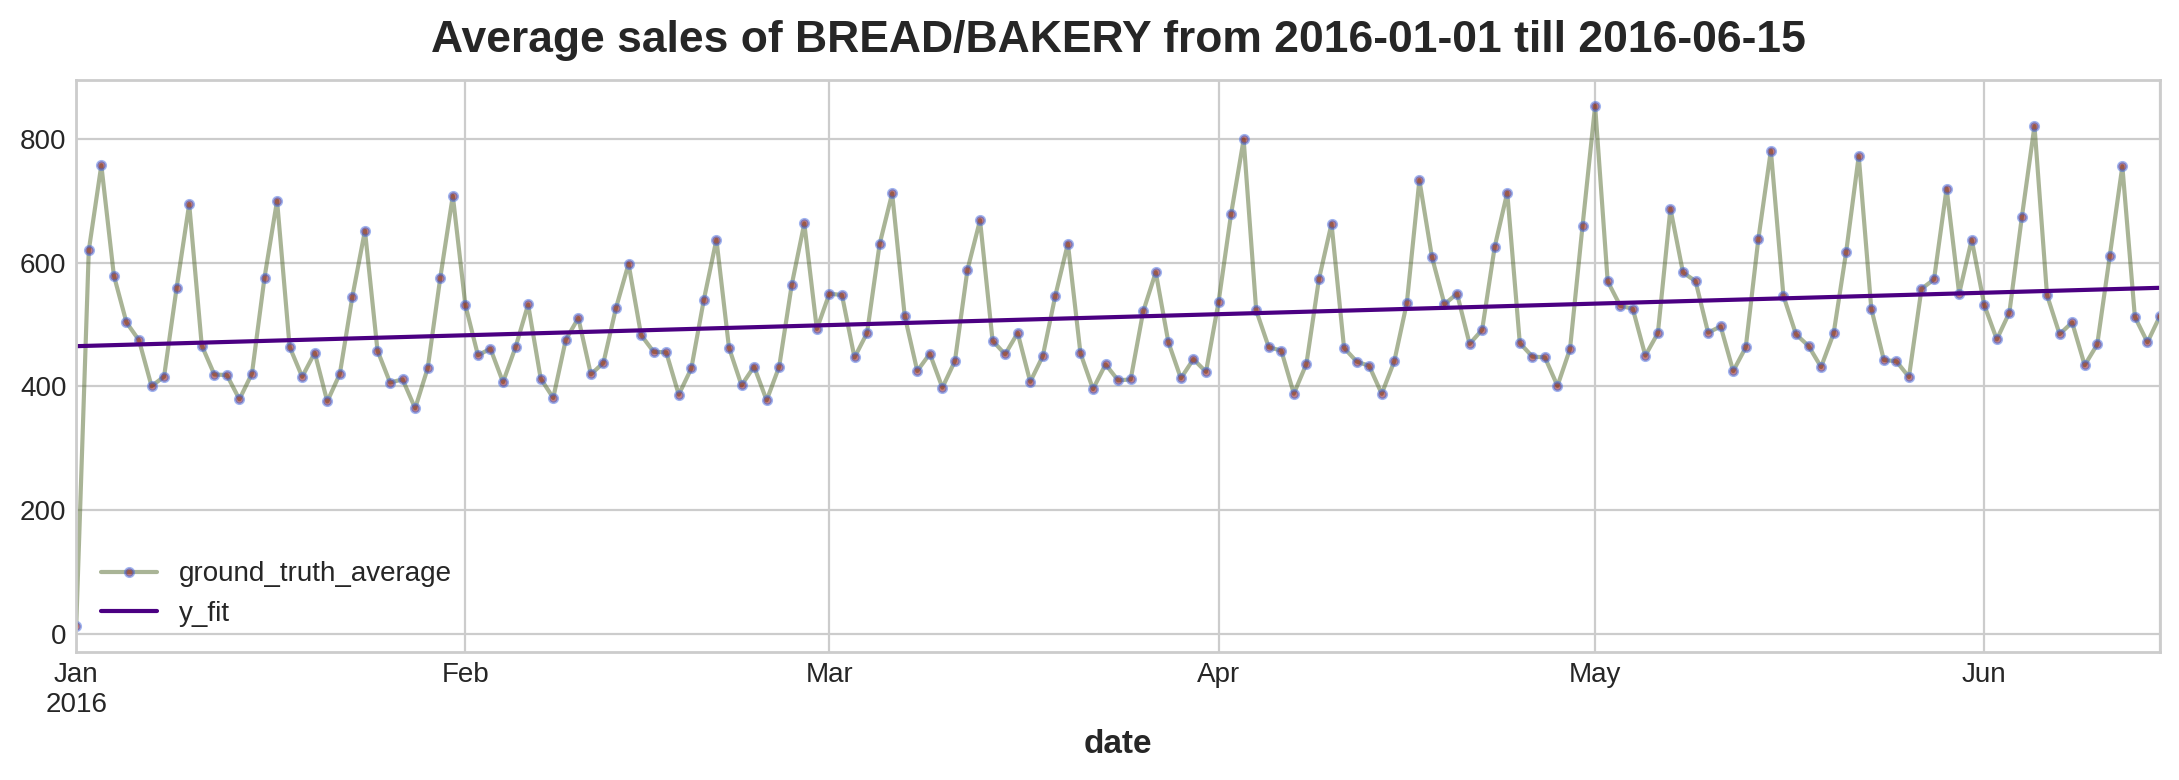

In [18]:
"""
Visualizing fitted curves against average sales (rather than per-family AND per-store) 
in this section is mainly to save trouble replicating the time_dummy across the MultiIndex levels.
"""
check(X_time)

In [20]:
"""
y_train has a 'wide' format and the model learns to predict not just 1 value, but 1782 at once.
"""
# base_model = LinearRegression (fit_intercept = False).fit(X_time, y_train)
joblib.dump(base_model, './data/baseline_model.pkl')

NameError: name 'base_model' is not defined

In [ ]:
# Create features for test set
X_time_test = dp.out_of_sample(steps=16)    # 'out_of_sample (16)' means along the next 16 time-index labels ('days' in our case)
X_time_test.index.name = 'date'

In [ ]:
base_model = joblib.load('/kaggle/input/timeseriescourse-models/baseline_model.pkl')
y_submit = pd.DataFrame(base_model.predict(X_time_test),               
                        index = X_time_test.index,      
                        columns = y_train.columns).clip(0.0)

In [ ]:
submission_0 = (y_submit
            .stack(['family', 'store_nbr'])
            .to_frame()
            .join(test.id)
            .rename(columns = {0:'sales'})
            .reset_index(drop=True)
            .reindex(columns = ['id','sales'])
            )
# submission_0.to_csv('/kaggle/working/submission.csv', index=False)

In [19]:
# try different ORDER values to see visualisation of my above statement
ORDER = 3

dp_2 = DeterministicProcess(index = index_,
                            constant = True, 
                            order = ORDER, 
                            drop = False)
X_time_1_test = dp.out_of_sample(steps=500)
X_time_n = dp_2.in_sample()
X_time_n_test = dp_2.out_of_sample(steps=500)
demo_model = LinearRegression (fit_intercept = False).fit(X_time_n, y_train)

y_order_1 = pd.DataFrame(base_model.predict(X_time),index = X_time.index,columns = y_train.columns)
y_order_1 = y_order_1.stack([0,1]).to_frame().query('family == @FAMILY and store_nbr == @STORE').reset_index(['family', 'store_nbr'],drop=True).squeeze()

y_order_1_fore = pd.DataFrame(base_model.predict(X_time_1_test),index = X_time_1_test.index,columns = y_train.columns)
y_order_1_fore = y_order_1_fore.stack([0,1]).to_frame().query('family == @FAMILY and store_nbr == @STORE').reset_index(['family', 'store_nbr'],drop=True).squeeze()

y_order_n = pd.DataFrame(demo_model.predict(X_time_n),index = X_time_n.index,columns = y_train.columns)
y_order_n = y_order_n.stack([0,1]).to_frame().query('family == @FAMILY and store_nbr == @STORE').reset_index(['family', 'store_nbr'],drop=True).squeeze()

y_order_n_fore = pd.DataFrame(demo_model.predict(X_time_n_test),index = X_time_n_test.index,columns = y_train.columns)
y_order_n_fore = y_order_n_fore.stack([0,1]).to_frame().query('family == @FAMILY and store_nbr == @STORE').reset_index(['family', 'store_nbr'],drop=True).squeeze()

y_fact = y_train.stack([0,1]).to_frame().query('family == @FAMILY and store_nbr == @STORE').reset_index(['family', 'store_nbr'],drop=True).squeeze()

ax = y_fact.plot (**plot_params, alpha = 0.3, label=f"ground truth")
ax = y_order_1.plot(ax=ax, label="Order_1_fit")
ax = y_order_1_fore.plot(ax=ax, label="Order_1_forecast", color="C2", linewidth = 3)
ax = y_order_n.plot(ax=ax, label=f"Order_{ORDER}_fit")
ax = y_order_n_fore.plot(ax=ax, label=f"Order_{ORDER}_forecast", color="C3", linewidth = 3)
ax.set_title (f'fits and predictions with a time_dummy for {FAMILY} at store {STORE}')
_ = ax.legend()

NameError: name 'base_model' is not defined

In [ ]:
# Create features for test set
X_time_test = dp.out_of_sample(steps=16)    # 'out_of_sample (16)' means along the next 16 time-index labels ('days' in our case)
X_time_test.index.name = 'date'

In [ ]:
base_model = joblib.load('/kaggle/input/timeseriescourse-models/baseline_model.pkl')
y_submit = pd.DataFrame(base_model.predict(X_time_test),               
                        index = X_time_test.index,      
                        columns = y_train.columns).clip(0.0)

In [ ]:
submission_0 = (y_submit
            .stack(['family', 'store_nbr'])
            .to_frame()
            .join(test.id)
            .rename(columns = {0:'sales'})
            .reset_index(drop=True)
            .reindex(columns = ['id','sales'])
            )
submission_0.to_csv('/kaggle/working/submission.csv', index=False)